## Import packages and world map

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import os
import numpy as np
from pandas import read_csv
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
from scipy import stats
import geopandas as gpd

In [2]:
world_gdf = gpd.read_file('outputs_poverty_model/ADMIN/Admin0_Polys.shp')

x_vars = ['shareag', 'sharemanu', 'shareemp', 'grserv', 'grag', 'grmanu',
          'skillpserv', 'skillpag', 'skillpmanu', 'p', 'b', 'voice'] 

for x in x_vars:
    world_gdf['indicator_global_{}'.format(x)] = 2
    world_gdf['indicator_local_{}'.format(x)] = 2

world_gdf = world_gdf.to_crs(epsg=4326)

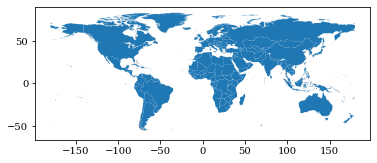

In [3]:
world_gdf.plot()

There are two types of simulation experiments conducted in Hallegatte & Rozenberg (2017). In the first one, all five climate impact channels are simultaneously accounted. In the second one, each channel is propagated to household income individually. We consider results from both the 'all' and 'separate' climate impact channels scenarios.

## All climate impacts

In [16]:
model = os.getcwd()
bau_folder   = model+'/outputs_poverty_model/baselines_sept2016_4/'
cc_folder    = model+'/outputs_poverty_model/with_cc_sept2016_4/'

bau_1 = read_csv(bau_folder+'outputs_spark_bau_0_200.csv', index_col=0)
bau_2 = read_csv(bau_folder+'outputs_spark_bau_200_300.csv', index_col=0)
bau = bau_1.append(bau_2)
bau['key'] = bau['country'] + '_' + bau['scenar'].astype(str) + '_' + bau['ssp']

cc_1 = read_csv(cc_folder+'outputs_spark_cc_0_200.csv', index_col=0)
cc_2 = read_csv(cc_folder+'outputs_spark_cc_200_300.csv', index_col=0)
cc = cc_1.append(cc_2)
cc['key'] = cc['country'] + '_' + cc['scenar'].astype(str) + '_' + cc['ssp']

In [5]:
diff_0 = bau.merge(cc.loc[cc['ccint']==0], left_on='key', right_on='key', suffixes=('', '_cc'))
diff_1 = bau.merge(cc.loc[cc['ccint']==1], left_on='key', right_on='key', suffixes=('', '_cc'))
diff = diff_0.append(diff_1)
diff.reset_index(inplace=True, drop=True)

In [6]:
diff['belowpovline_diff'] = (diff['belowpovline_cc'] - diff['belowpovline']) / diff['tot_pop'] * 100
diff['belowpovline_cc'] = diff['belowpovline_cc'] / diff['tot_pop'] *  100

In [17]:
x_vars = ['shareag', 'sharemanu', 'shareemp', 'grserv', 'grag', 'grmanu',
          'skillpserv', 'skillpag', 'skillpmanu', 'p', 'b', 'voice'] 
y_vars = ['belowpovline_cc', 'belowpovline_diff']

for country in np.unique(diff['country']):
    for x in x_vars:
        world_gdf.loc[world_gdf['ISO3']==country, 'indicator_global_{}'.format(x)] = 1
    
for country in np.unique(diff['country']):
    diff_c = diff.loc[(diff['country']==country) & (diff['belowpovline_diff']>0.01)]

    x = diff_c[x_vars]
    x = x.astype(float)
    y = diff_c[y_vars]
    
    try:
        ols = pd.DataFrame()
        ols['x_vars'] = x_vars

        for y_var in y_vars:
            mod = sm.OLS(y[y_var].values, np.asarray(x))
            res = mod.fit()
            ols['pvalues_'+y_var] = res.pvalues
            ols['tvalues_'+y_var] = res.tvalues

        ols = ols.loc[(ols['pvalues_'+y_vars[0]]<0.01) & (ols['pvalues_'+y_vars[1]]<0.01)]
        ols['opposite'] = ols.apply(lambda x: x['tvalues_'+y_vars[0]] * x['tvalues_'+y_vars[1]] < 0, axis=1)
        ols = ols.loc[ols['opposite']==True]
        if len(ols['x_vars'].values) > 0:
            for var in ols['x_vars'].values:
                diff_c['{}_high'.format(var)] = diff_c[var] > np.median(diff_c[var])
                
                cc_high = diff_c.loc[diff_c['{}_high'.format(var)]==True][y_vars[0]].values
                cc_low = diff_c.loc[diff_c['{}_high'.format(var)]==False][y_vars[0]].values
                _, pvalue_cc = stats.ttest_ind(cc_high,cc_low)
                
                diff_high = diff_c.loc[diff_c['{}_high'.format(var)]==True][y_vars[1]].values
                diff_low = diff_c.loc[diff_c['{}_high'.format(var)]==False][y_vars[1]].values
                _, pvalue_diff = stats.ttest_ind(diff_high,diff_low)
                    
                if np.median(cc_high) < np.median(cc_low) and np.median(diff_high) > np.median(diff_low):
                    if pvalue_cc < 0.05 and pvalue_diff < 0.05:
                        world_gdf.loc[world_gdf['ISO3']==country, 'indicator_global_{}'.format(var)] = 0
                
    except:
        pass

## Separate climate impacts

In [8]:
model = os.getcwd()
bau_folder   = model+'/outputs_poverty_model/baseline_sept2016_separate_impacts/'
cc_folder    = model+'/outputs_poverty_model/with_cc_sept2016_separate_impacts/'

list_bau = os.listdir(bau_folder)
list_cc = os.listdir(cc_folder)

bau = pd.DataFrame()
cc = pd.DataFrame()
diff = pd.DataFrame()

for file in list_bau:
    if 'csv' in file:
        bau_1 = read_csv(bau_folder+file, index_col=0)
        bau = bau.append(bau_1)
        
bau['key'] = bau['country'] + '_' + bau['scenar'].astype(str) + '_' + bau['ssp']
bau.drop_duplicates('key', inplace=True)
        
for file in list_cc:
    if 'csv' in file:
        cc_1 = read_csv(cc_folder+file, index_col=0)
        cc_1['key'] = cc_1['country'] + '_' + cc_1['scenar'].astype(str) + '_' + cc_1['ssp']
        cc = cc.append(cc_1)
        diff_0 = bau.merge(cc_1, left_on='key', right_on='key', suffixes=('', '_cc'))
        diff = diff.append(diff_0)
        
diff.dropna(inplace=True)

In [9]:
diff['below2_diff'] = (diff['below2_cc'] - diff['below2']) / diff['tot_pop'] * 100
diff['below2_cc'] = diff['below2_cc'] / diff['tot_pop'] *  100

In [18]:
x_vars = ['shareag', 'sharemanu', 'shareemp', 'grserv', 'grag', 'grmanu',
          'skillpserv', 'skillpag', 'skillpmanu', 'p', 'b', 'voice'] 
y_vars = ['below2_cc', 'below2_diff']

for country in np.unique(diff['country']):
    for x in x_vars:
        world_gdf.loc[world_gdf['ISO3']==country, 'indicator_local_{}'.format(x)] = 1

for country in np.unique(diff['country']):
    diff_c = diff.loc[(diff['country']==country) & (diff['below2_diff']>0.01) & (diff['below2_diff']<2)]

    x = diff_c[x_vars]
    x = x.astype(float)
    y = diff_c[y_vars]
    
    try:
        ols = pd.DataFrame()
        ols['x_vars'] = x_vars

        for y_var in y_vars:
            mod = sm.OLS(y[y_var].values, np.asarray(x))
            res = mod.fit()
            ols['pvalues_'+y_var] = res.pvalues
            ols['tvalues_'+y_var] = res.tvalues

        ols = ols.loc[(ols['pvalues_'+y_vars[0]]<0.01) & (ols['pvalues_'+y_vars[1]]<0.01)]
        ols['opposite'] = ols.apply(lambda x: x['tvalues_'+y_vars[0]] * x['tvalues_'+y_vars[1]] < 0, axis=1)
        ols = ols.loc[ols['opposite']==True]
        if len(ols['x_vars'].values) > 0:
            for var in ols['x_vars'].values:
                diff_c['{}_high'.format(var)] = diff_c[var] > np.median(diff_c[var])
                
                cc_high = diff_c.loc[diff_c['{}_high'.format(var)]==True][y_vars[0]].values
                cc_low = diff_c.loc[diff_c['{}_high'.format(var)]==False][y_vars[0]].values
                _, pvalue_cc = stats.ttest_ind(cc_high,cc_low)
                
                diff_high = diff_c.loc[diff_c['{}_high'.format(var)]==True][y_vars[1]].values
                diff_low = diff_c.loc[diff_c['{}_high'.format(var)]==False][y_vars[1]].values
                _, pvalue_diff = stats.ttest_ind(diff_high,diff_low)
                
                if np.median(cc_high) < np.median(cc_low) and np.median(diff_high) > np.median(diff_low):
                    if pvalue_cc < 0.05 and pvalue_diff < 0.05:
                        world_gdf.loc[world_gdf['ISO3']==country, 'indicator_local_{}'.format(var)] = 0
                
    except:
        pass

## Draw the map

In [11]:
for x in x_vars:
    world_gdf['indicator_{}'.format(x)] = world_gdf[['indicator_global_{}'.format(x), 'indicator_local_{}'.format(x)]].min(axis=1)
    world_gdf['indicator_{}'.format(x)] = world_gdf['indicator_{}'.format(x)].astype(str)
    world_gdf['indicator_global_{}'.format(x)] = world_gdf['indicator_global_{}'.format(x)].astype(str)
    world_gdf['indicator_local_{}'.format(x)] = world_gdf['indicator_local_{}'.format(x)].astype(str)

In [12]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

color_dict = {}
color_dict['0'] = 'salmon' #Opposing impacts
color_dict['1'] = 'cornflowerblue' #Agreeing impacts
color_dict['2'] = 'lightgray' #No data

clusdict={'0.0': 'Opposing impacts', '1.0': 'Agreeing impacts', '2.0': 'No data'}

In [13]:
palette = dict(zip(sorted(world_gdf['indicator_b'].unique()),
               [cm.tab10(x) for x in range(world_gdf['indicator_b'].nunique())]))

cmap = ListedColormap([color for decile, color in color_dict.items()
                       if decile in world_gdf['indicator_b'].unique()])

In [14]:
def plot_impacts(indicator, title, ax=None, loc=None, legend=True):
    
    if ax==None:
        fig, ax = plt.subplots(1, 1, figsize=(14,8))
        
    if loc:
        ax.text(0.5,-0.01, title, transform=ax.transAxes, fontsize=25)
    else:
        plt.title(title)
        
    world_gdf.plot(indicator, cmap=cmap, legend=legend, ax=ax)

    def replace_legend_items(legend, mapping):
        for txt in legend.texts:
            for k,v in mapping.items():
                if txt.get_text() == str(k):
                    txt.set_text(v)

    if legend==True:
        replace_legend_items(ax.get_legend(), clusdict)
        leg = ax.get_legend()
        leg.set_bbox_to_anchor((0.3,0.35))

    for pos in ['top', 'right', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)

    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    

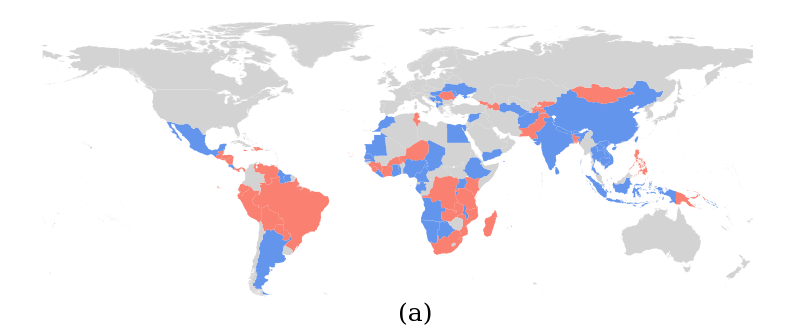

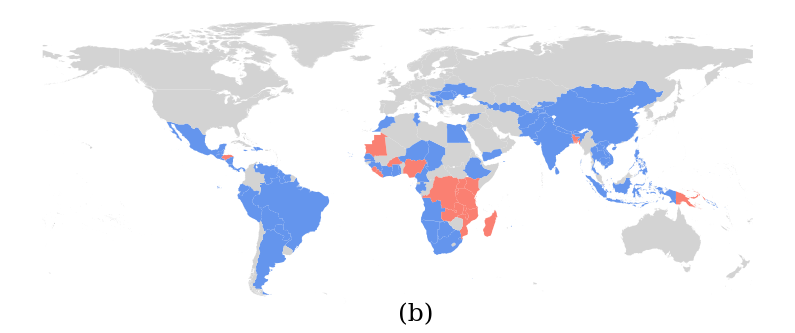

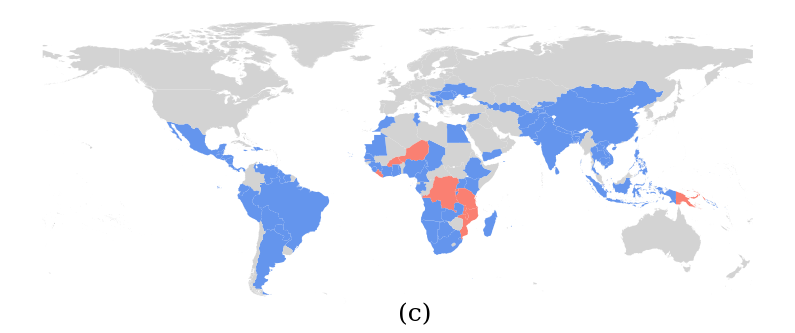

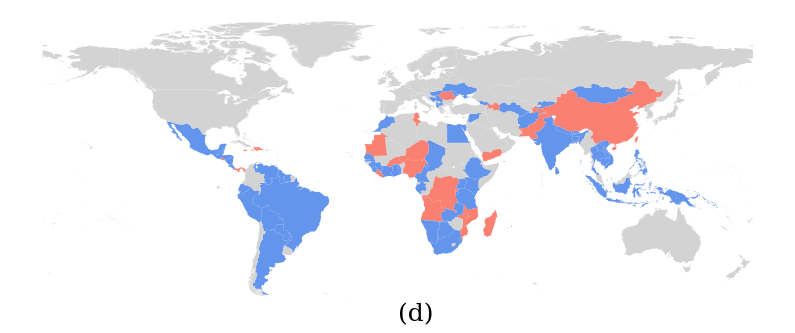

In [15]:
indicator = 'indicator_b'
title = '(a)'
plot_impacts(indicator, title, loc='below', legend=False)
plt.savefig('figs/world_map_{}.jpeg'.format(indicator), dpi=400, bbox_inches='tight')
plt.show()

indicator = 'indicator_grag'
title = '(b)'
plot_impacts(indicator, title, loc='below', legend=False)
plt.savefig('figs/world_map_{}.jpeg'.format(indicator), dpi=400, bbox_inches='tight')
plt.show()

indicator = 'indicator_grmanu'
title = '(c)'
plot_impacts(indicator, title, loc='below', legend=False)
plt.savefig('figs/world_map_{}.jpeg'.format(indicator), dpi=400, bbox_inches='tight')
plt.show()

indicator = 'indicator_grserv'
title = '(d)'
plot_impacts(indicator, title, loc='below', legend=False)
plt.savefig('figs/world_map_{}.jpeg'.format(indicator), dpi=400, bbox_inches='tight')
plt.show()